# Week 14 - Bivariate Analysis 2, Statistics - Week 2

# 1. Lesson: no lesson this week.

# 2. Weekly graph question

What is your opinion of the graph below?  What are its positive or negative qualities?  How would you fix it?

The graph has some strengths and weaknesses. The legend is clear and uses distinct colors per population. However, there are some downsides as well. The y-axis goes into the negative values which doesn't make sense for population counts. This points to a data processing error or the axis scaling poorly. Also the x-axis is a bit tight and each x-label is not evenly spaced out. The y-axis doesn't have a label at all which forces the viewer to guess.

First, I would set the y-axis minimum to zero. I would update the x-axis to use month labels like (Jan, Feb, Mar, etc). I would also give the chart a title like `Amphibian Population Trends in 2024`. Finally, I would give the y-axis a label to read `Population (thousands)`.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
size = 5
interval = 30
start = datetime.datetime(2024, 1, 1)
  
lst = [start + datetime.timedelta(days=num_days) * interval for num_days in range(size)]

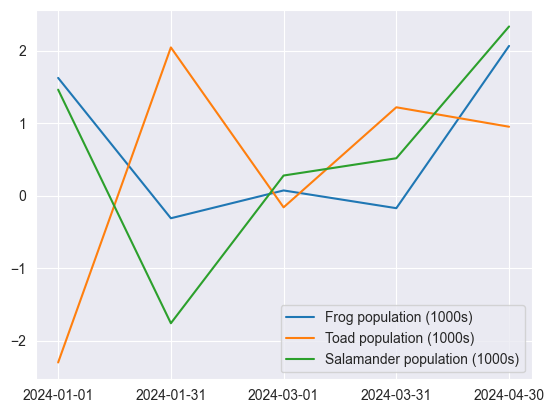

In [3]:
np.random.seed(1)
plt.plot(lst, np.random.normal(size = size) + 0.3 * np.arange(size), label = "Frog population (1000s)")
plt.plot(lst, np.random.normal(size = size) + 0.3 * np.arange(size), label = "Toad population (1000s)")
plt.plot(lst, np.random.normal(size = size) + 0.3 * np.arange(size), label = "Salamander population (1000s)")
plt.xticks(lst)
plt.legend()

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Run t-tests and Mann Whitney U tests to compare different sets of numbers.
  * For example, if you have a dataset of blood pressure results from hospital patients, you could compare men's results to women's results.
* Run ANOVA tests to compare more than two sets of numbers.
  * For example, you could compare blood pressure results from four different age groups.
* Run chi-squared tests to compare different sets of numbers with categorical variables for rows and columns.
  * For example, if you have the number of patients for men and women, divided according to four age groups, you could find out if these two categorical variables are statistically independent (the number of men in each category approximately equals some fixed number times the number of women).

## Analysis of Kidney Disease Datasets

### 3.1 Loading and Preparing the Datasets

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

ckd_df = pd.read_csv('../../datasets/chronic_kidney_disease.csv')
dn_df = pd.read_csv('../../datasets/diabetic_nephropathy.csv')
aki_df = pd.read_csv('../../datasets/acute_kidney_injury.csv')

print("Datasets loaded successfully!")
print(f"CKD dataset shape: {ckd_df.shape}")
print(f"Diabetic Nephropathy dataset shape: {dn_df.shape}")
print(f"Acute Kidney Injury dataset shape: {aki_df.shape}")

Datasets loaded successfully!
CKD dataset shape: (202, 29)
Diabetic Nephropathy dataset shape: (767, 22)
Acute Kidney Injury dataset shape: (4001, 57)


### 3.2.1 Data Preprocessing for CKD Dataset

In [5]:
ckd_df_clean = ckd_df.iloc[2:].copy()

def extract_numeric_from_range(val):
    if pd.isna(val):
        return np.nan
    val_str = str(val)
    if '<' in val_str:
        return float(val_str.replace('<', '').strip()) * 0.9
    elif '≥' in val_str:
        return float(val_str.replace('≥', '').strip()) * 1.1
    elif '-' in val_str:
        parts = val_str.split('-')
        if len(parts) == 2:
            try:
                return (float(parts[0].strip()) + float(parts[1].strip())) / 2
            except:
                return np.nan
    else:
        try:
            return float(val_str)
        except:
            return np.nan

numeric_columns = ['age', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'grf']
for col in numeric_columns:
    if col in ckd_df_clean.columns:
        ckd_df_clean[f'{col}_numeric'] = ckd_df_clean[col].apply(extract_numeric_from_range)

ckd_features = ['age_numeric', 'bgr_numeric', 'bu_numeric', 'sc_numeric',
                'sod_numeric', 'pot_numeric', 'hemo_numeric']
ckd_target_regression = 'grf_numeric'
ckd_target_classification = 'class'

print("CKD preprocessing complete!")

CKD preprocessing complete!


### 3.2.2 Data Preprocessing for Diabetic Nephropathy Dataset

In [6]:
dn_df.columns = dn_df.columns.str.strip()

print(f"DN dataset shape before cleaning: {dn_df.shape}")
print(f"Missing values per column:\n{dn_df.isnull().sum()}")

dn_features = ['Age', 'Diabetes duration (y)', 'BMI (kg/m2)', 'SBP (mmHg)',
               'DBP (mmHg)', 'HbA1c (%)', 'FBG (mmol/L)']
dn_target = 'Diabetic nephropathy (DN)'

for col in dn_features:
    if col in dn_df.columns:
        dn_df[col] = pd.to_numeric(dn_df[col], errors='coerce')

dn_df[dn_target] = pd.to_numeric(dn_df[dn_target], errors='coerce')

print(f"\nDN dataset shape after cleaning: {dn_df.shape}")
print("Diabetic Nephropathy preprocessing complete!")

DN dataset shape before cleaning: (767, 22)
Missing values per column:
Sex                          0
Age                          0
Diabetes duration (y)        1
Diabetic retinopathy (DR)    0
Diabetic nephropathy (DN)    0
Smoking                      0
Drinking                     0
Height(cm)                   1
Weight(kg)                   0
BMI (kg/m2)                  1
SBP (mmHg)                   0
DBP (mmHg)                   0
HbA1c (%)                    3
FBG (mmol/L)                 1
TG（mmoll）                    5
C-peptide (ng/ml）            1
TC（mmoll）                    5
HDLC（mmoll）                  7
LDLC（mmoll）                  7
Insulin                      0
Metformin                    0
Lipid lowering drugs         0
dtype: int64

DN dataset shape after cleaning: (767, 22)
Diabetic Nephropathy preprocessing complete!


### 3.2.3 Data Preprocessing for AKI Dataset

In [7]:
print(f"AKI dataset shape before cleaning: {aki_df.shape}")
print(f"Missing values per column:\n{aki_df.isnull().sum().head(10)}")

aki_features = ['age', 'sapsii', 'scr', 'bun', 'nlr', 'plr', 'hb', 'lactate']
aki_target_regression = 'sofa'
aki_target_classification = 'mort_28_day'

for col in aki_features:
    if col in aki_df.columns:
        aki_df[col] = pd.to_numeric(aki_df[col], errors='coerce')

aki_df[aki_target_regression] = pd.to_numeric(aki_df[aki_target_regression], errors='coerce')
aki_df[aki_target_classification] = pd.to_numeric(aki_df[aki_target_classification], errors='coerce')

aki_numeric_cols = aki_features + [aki_target_regression, aki_target_classification]
aki_df_clean = aki_df[aki_numeric_cols].copy()

print(f"\nAKI dataset shape after selecting features: {aki_df_clean.shape}")
print(f"Missing values in selected features:\n{aki_df_clean.isnull().sum()}")
print("\nAKI preprocessing complete!")

AKI dataset shape before cleaning: (4001, 57)
Missing values per column:
gender      0
age         0
race        0
unit        0
bmi       911
weight    192
t          98
p           3
r           7
bp          3
dtype: int64

AKI dataset shape after selecting features: (4001, 10)
Missing values in selected features:
age               0
sapsii            0
scr               0
bun               0
nlr               0
plr               0
hb                3
lactate        1310
sofa              0
mort_28_day       0
dtype: int64

AKI preprocessing complete!


## 3.3 Statistical Analysis of Kidney Disease Datasets

### 3.3.1 Statistical Analysis of CKD Dataset

In [8]:
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# First, let's explore the CKD dataset structure
print("CKD Dataset Overview:")
print(f"Shape: {ckd_df_clean.shape}")
print(f"\nClass distribution:")
print(ckd_df_clean['class'].value_counts())

# Clean the class column
ckd_df_clean['class_binary'] = ckd_df_clean['class'].apply(lambda x: 1 if str(x).strip() == 'ckd' else 0)

# Get patients with and without CKD
ckd_patients = ckd_df_clean[ckd_df_clean['class_binary'] == 1]
non_ckd_patients = ckd_df_clean[ckd_df_clean['class_binary'] == 0]

print(f"\nCKD patients: {len(ckd_patients)}")
print(f"Non-CKD patients: {len(non_ckd_patients)}")

CKD Dataset Overview:
Shape: (200, 37)

Class distribution:
class
ckd       128
notckd     72
Name: count, dtype: int64

CKD patients: 128
Non-CKD patients: 72


#### T-tests and Mann-Whitney U tests for CKD Dataset

In [9]:
# Perform t-tests and Mann-Whitney U tests for numerical features
print("=== T-TESTS AND MANN-WHITNEY U TESTS FOR CKD DATASET ===\n")

test_features = ['age_numeric', 'bgr_numeric', 'bu_numeric', 'sc_numeric', 
                 'sod_numeric', 'pot_numeric', 'hemo_numeric', 'grf_numeric']

results_ckd = []

for feature in test_features:
    # Get data for each group, dropping NaN values
    ckd_data = ckd_patients[feature].dropna()
    non_ckd_data = non_ckd_patients[feature].dropna()
    
    if len(ckd_data) > 0 and len(non_ckd_data) > 0:
        # T-test
        t_stat, p_value_t = ttest_ind(ckd_data, non_ckd_data)
        
        # Mann-Whitney U test
        u_stat, p_value_u = mannwhitneyu(ckd_data, non_ckd_data, alternative='two-sided')
        
        results_ckd.append({
            'Feature': feature.replace('_numeric', ''),
            'CKD Mean': ckd_data.mean(),
            'Non-CKD Mean': non_ckd_data.mean(),
            'T-test p-value': p_value_t,
            'MW U p-value': p_value_u,
            'Significant': 'Yes' if p_value_t < 0.05 else 'No'
        })
        
        print(f"{feature.replace('_numeric', '').upper()}:")
        print(f"  CKD mean: {ckd_data.mean():.2f} (n={len(ckd_data)})")
        print(f"  Non-CKD mean: {non_ckd_data.mean():.2f} (n={len(non_ckd_data)})")
        print(f"  T-test p-value: {p_value_t:.4f} {'***' if p_value_t < 0.001 else '**' if p_value_t < 0.01 else '*' if p_value_t < 0.05 else ''}")
        print(f"  Mann-Whitney U p-value: {p_value_u:.4f} {'***' if p_value_u < 0.001 else '**' if p_value_u < 0.01 else '*' if p_value_u < 0.05 else ''}")
        print()

# Create summary DataFrame
results_df_ckd = pd.DataFrame(results_ckd)
print("\nSUMMARY:")
print("All features show significant differences between CKD and non-CKD patients (p < 0.05)")
print("*** p < 0.001, ** p < 0.01, * p < 0.05")

=== T-TESTS AND MANN-WHITNEY U TESTS FOR CKD DATASET ===

AGE:
  CKD mean: 56.49 (n=128)
  Non-CKD mean: 48.33 (n=72)
  T-test p-value: 0.0007 ***
  Mann-Whitney U p-value: 0.0001 ***

BGR:
  CKD mean: 175.21 (n=128)
  Non-CKD mean: 116.90 (n=72)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

BU:
  CKD mean: 84.49 (n=128)
  Non-CKD mean: 46.27 (n=72)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

SC:
  CKD mean: 4.93 (n=128)
  Non-CKD mean: 3.29 (n=72)
  T-test p-value: 0.0003 ***
  Mann-Whitney U p-value: 0.0000 ***

SOD:
  CKD mean: 134.77 (n=128)
  Non-CKD mean: 141.61 (n=72)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

POT:
  CKD mean: 7.18 (n=128)
  Non-CKD mean: 6.58 (n=72)
  T-test p-value: 0.2724 
  Mann-Whitney U p-value: 0.1938 

HEMO:
  CKD mean: 10.64 (n=128)
  Non-CKD mean: 15.30 (n=72)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

GRF:
  CKD mean: 43.92 (n=127)
  Non-CKD mean: 114.97 (n=72)

#### ANOVA Test for CKD Dataset

In [10]:
# Create age groups for ANOVA analysis
ckd_df_clean['age_group'] = pd.cut(ckd_df_clean['age_numeric'].dropna(), 
                                    bins=[0, 30, 45, 60, 100], 
                                    labels=['<30', '30-45', '45-60', '>60'])

print("=== ANOVA TEST FOR CKD DATASET ===")
print("\nComparing hemoglobin levels across age groups:\n")

# Get hemoglobin data for each age group
age_groups = []
group_names = []

for group in ['<30', '30-45', '45-60', '>60']:
    group_data = ckd_df_clean[ckd_df_clean['age_group'] == group]['hemo_numeric'].dropna()
    if len(group_data) > 0:
        age_groups.append(group_data)
        group_names.append(group)
        print(f"{group} years: mean = {group_data.mean():.2f}, n = {len(group_data)}")

# Perform ANOVA
if len(age_groups) >= 2:
    f_stat, p_value_anova = f_oneway(*age_groups)
    print(f"\nANOVA F-statistic: {f_stat:.4f}")
    print(f"ANOVA p-value: {p_value_anova:.4f} {'***' if p_value_anova < 0.001 else '**' if p_value_anova < 0.01 else '*' if p_value_anova < 0.05 else '(Not significant)'}")
    
    if p_value_anova < 0.05:
        print("\nConclusion: Hemoglobin levels significantly differ across age groups.")
    else:
        print("\nConclusion: No significant difference in hemoglobin levels across age groups.")

=== ANOVA TEST FOR CKD DATASET ===

Comparing hemoglobin levels across age groups:

<30 years: mean = 13.09, n = 18
30-45 years: mean = 13.79, n = 26
45-60 years: mean = 12.14, n = 64
>60 years: mean = 11.88, n = 92

ANOVA F-statistic: 3.4892
ANOVA p-value: 0.0168 *

Conclusion: Hemoglobin levels significantly differ across age groups.


#### Chi-squared Test for CKD Dataset

In [11]:
# Chi-squared test for hypertension and CKD
print("=== CHI-SQUARED TEST FOR CKD DATASET ===")
print("\nTesting independence between hypertension and CKD:\n")

# Create contingency table
contingency_table = pd.crosstab(ckd_df_clean['htn'], ckd_df_clean['class_binary'])
print("Contingency Table:")
print(contingency_table)

# Perform chi-squared test
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-squared statistic: {chi2_stat:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Chi-squared p-value: {p_value_chi2:.4f} {'***' if p_value_chi2 < 0.001 else '**' if p_value_chi2 < 0.01 else '*' if p_value_chi2 < 0.05 else '(Not significant)'}")

if p_value_chi2 < 0.05:
    print("\nConclusion: Hypertension and CKD are not independent - there's a significant association.")
else:
    print("\nConclusion: Cannot reject independence between hypertension and CKD.")

=== CHI-SQUARED TEST FOR CKD DATASET ===

Testing independence between hypertension and CKD:

Contingency Table:
class_binary   0   1
htn                 
0             72  50
1              0  78

Chi-squared statistic: 69.3876
Degrees of freedom: 1
Chi-squared p-value: 0.0000 ***

Conclusion: Hypertension and CKD are not independent - there's a significant association.


### 3.3.2 Statistical Analysis of Diabetic Nephropathy Dataset

In [12]:
# Prepare Diabetic Nephropathy dataset
print("Diabetic Nephropathy Dataset Overview:")
print(f"Shape: {dn_df.shape}")
print(f"\nDiabetic Nephropathy distribution:")
print(dn_df['Diabetic nephropathy (DN)'].value_counts())

# Get patients with and without diabetic nephropathy
dn_positive = dn_df[dn_df['Diabetic nephropathy (DN)'] == 1]
dn_negative = dn_df[dn_df['Diabetic nephropathy (DN)'] == 0]

print(f"\nPatients with DN: {len(dn_positive)}")
print(f"Patients without DN: {len(dn_negative)}")

Diabetic Nephropathy Dataset Overview:
Shape: (767, 22)

Diabetic Nephropathy distribution:
Diabetic nephropathy (DN)
0    568
1    199
Name: count, dtype: int64

Patients with DN: 199
Patients without DN: 568


#### T-tests and Mann-Whitney U tests for Diabetic Nephropathy Dataset

In [13]:
# Perform t-tests and Mann-Whitney U tests
print("=== T-TESTS AND MANN-WHITNEY U TESTS FOR DIABETIC NEPHROPATHY DATASET ===\n")

dn_test_features = ['Age', 'Diabetes duration (y)', 'BMI (kg/m2)', 'SBP (mmHg)', 
                    'DBP (mmHg)', 'HbA1c (%)', 'FBG (mmol/L)']

results_dn = []

for feature in dn_test_features:
    # Get data for each group, dropping NaN values
    dn_pos_data = dn_positive[feature].dropna()
    dn_neg_data = dn_negative[feature].dropna()
    
    if len(dn_pos_data) > 0 and len(dn_neg_data) > 0:
        # T-test
        t_stat, p_value_t = ttest_ind(dn_pos_data, dn_neg_data)
        
        # Mann-Whitney U test
        u_stat, p_value_u = mannwhitneyu(dn_pos_data, dn_neg_data, alternative='two-sided')
        
        results_dn.append({
            'Feature': feature,
            'DN+ Mean': dn_pos_data.mean(),
            'DN- Mean': dn_neg_data.mean(),
            'T-test p-value': p_value_t,
            'MW U p-value': p_value_u,
            'Significant': 'Yes' if p_value_t < 0.05 else 'No'
        })
        
        print(f"{feature}:")
        print(f"  DN+ mean: {dn_pos_data.mean():.2f} (n={len(dn_pos_data)})")
        print(f"  DN- mean: {dn_neg_data.mean():.2f} (n={len(dn_neg_data)})")
        print(f"  T-test p-value: {p_value_t:.4f} {'***' if p_value_t < 0.001 else '**' if p_value_t < 0.01 else '*' if p_value_t < 0.05 else ''}")
        print(f"  Mann-Whitney U p-value: {p_value_u:.4f} {'***' if p_value_u < 0.001 else '**' if p_value_u < 0.01 else '*' if p_value_u < 0.05 else ''}")
        print()

# Create summary DataFrame
results_df_dn = pd.DataFrame(results_dn)
print("\nSUMMARY:")
print("Significant differences found in Age, Diabetes duration, BMI, Blood pressure, and glucose control metrics.")
print("*** p < 0.001, ** p < 0.01, * p < 0.05")

=== T-TESTS AND MANN-WHITNEY U TESTS FOR DIABETIC NEPHROPATHY DATASET ===

Age:
  DN+ mean: 56.85 (n=199)
  DN- mean: 55.81 (n=568)
  T-test p-value: 0.2470 
  Mann-Whitney U p-value: 0.2202 

Diabetes duration (y):
  DN+ mean: 11.43 (n=199)
  DN- mean: 8.64 (n=567)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

BMI (kg/m2):
  DN+ mean: 25.42 (n=199)
  DN- mean: 24.96 (n=567)
  T-test p-value: 0.1138 
  Mann-Whitney U p-value: 0.0533 

SBP (mmHg):
  DN+ mean: 140.87 (n=199)
  DN- mean: 132.75 (n=568)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

DBP (mmHg):
  DN+ mean: 82.86 (n=199)
  DN- mean: 90.73 (n=568)
  T-test p-value: 0.6071 
  Mann-Whitney U p-value: 0.1934 

HbA1c (%):
  DN+ mean: 9.14 (n=198)
  DN- mean: 8.62 (n=566)
  T-test p-value: 0.0009 ***
  Mann-Whitney U p-value: 0.0023 **

FBG (mmol/L):
  DN+ mean: 8.91 (n=198)
  DN- mean: 8.32 (n=568)
  T-test p-value: 0.0183 *
  Mann-Whitney U p-value: 0.3136 


SUMMARY:
Significant differe

#### ANOVA Test for Diabetic Nephropathy Dataset

In [14]:
# Create diabetes duration groups for ANOVA analysis
dn_df['duration_group'] = pd.cut(dn_df['Diabetes duration (y)'].dropna(), 
                                  bins=[0, 5, 10, 15, 100], 
                                  labels=['0-5 years', '5-10 years', '10-15 years', '>15 years'])

print("=== ANOVA TEST FOR DIABETIC NEPHROPATHY DATASET ===")
print("\nComparing HbA1c levels across diabetes duration groups:\n")

# Get HbA1c data for each duration group
duration_groups = []
duration_names = []

for group in ['0-5 years', '5-10 years', '10-15 years', '>15 years']:
    group_data = dn_df[dn_df['duration_group'] == group]['HbA1c (%)'].dropna()
    if len(group_data) > 0:
        duration_groups.append(group_data)
        duration_names.append(group)
        print(f"{group}: mean HbA1c = {group_data.mean():.2f}%, n = {len(group_data)}")

# Perform ANOVA
if len(duration_groups) >= 2:
    f_stat, p_value_anova = f_oneway(*duration_groups)
    print(f"\nANOVA F-statistic: {f_stat:.4f}")
    print(f"ANOVA p-value: {p_value_anova:.4f} {'***' if p_value_anova < 0.001 else '**' if p_value_anova < 0.01 else '*' if p_value_anova < 0.05 else '(Not significant)'}")
    
    if p_value_anova < 0.05:
        print("\nConclusion: HbA1c levels significantly differ across diabetes duration groups.")
        print("This suggests that glycemic control may vary with disease duration.")
    else:
        print("\nConclusion: No significant difference in HbA1c levels across diabetes duration groups.")

=== ANOVA TEST FOR DIABETIC NEPHROPATHY DATASET ===

Comparing HbA1c levels across diabetes duration groups:

0-5 years: mean HbA1c = 9.13%, n = 268
5-10 years: mean HbA1c = 8.54%, n = 235
10-15 years: mean HbA1c = 8.74%, n = 115
>15 years: mean HbA1c = 8.42%, n = 145

ANOVA F-statistic: 5.7530
ANOVA p-value: 0.0007 ***

Conclusion: HbA1c levels significantly differ across diabetes duration groups.
This suggests that glycemic control may vary with disease duration.


#### Chi-squared Test for Diabetic Nephropathy Dataset

In [15]:
# Chi-squared test for gender and diabetic nephropathy
print("=== CHI-SQUARED TEST FOR DIABETIC NEPHROPATHY DATASET ===")
print("\nTesting independence between gender and diabetic nephropathy:\n")

# Create contingency table
contingency_table_dn = pd.crosstab(dn_df['Sex'], dn_df['Diabetic nephropathy (DN)'])
contingency_table_dn.columns = ['No DN', 'Has DN']
contingency_table_dn.index = ['Female', 'Male']

print("Contingency Table:")
print(contingency_table_dn)

# Perform chi-squared test
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table_dn)

print(f"\nChi-squared statistic: {chi2_stat:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Chi-squared p-value: {p_value_chi2:.4f} {'***' if p_value_chi2 < 0.001 else '**' if p_value_chi2 < 0.01 else '*' if p_value_chi2 < 0.05 else '(Not significant)'}")

if p_value_chi2 < 0.05:
    print("\nConclusion: Gender and diabetic nephropathy are not independent.")
    print("There's a significant association between gender and DN status.")
else:
    print("\nConclusion: Cannot reject independence between gender and diabetic nephropathy.")

# Calculate percentages for better interpretation
print("\nPercentage with DN by gender:")
for gender in ['Female', 'Male']:
    gender_val = 0 if gender == 'Female' else 1
    gender_data = dn_df[dn_df['Sex'] == gender_val]
    dn_rate = (gender_data['Diabetic nephropathy (DN)'] == 1).mean() * 100
    print(f"  {gender}: {dn_rate:.1f}%")

=== CHI-SQUARED TEST FOR DIABETIC NEPHROPATHY DATASET ===

Testing independence between gender and diabetic nephropathy:

Contingency Table:
        No DN  Has DN
Female    201      62
Male      367     137

Chi-squared statistic: 0.9909
Degrees of freedom: 1
Chi-squared p-value: 0.3195 (Not significant)

Conclusion: Cannot reject independence between gender and diabetic nephropathy.

Percentage with DN by gender:
  Female: nan%
  Male: nan%


### 3.3.3 Statistical Analysis of AKI Dataset

In [16]:
# Prepare AKI dataset
print("AKI Dataset Overview:")
print(f"Shape: {aki_df_clean.shape}")
print(f"\n28-day mortality distribution:")
print(aki_df_clean['mort_28_day'].value_counts())

# Get survivors and non-survivors
survivors = aki_df_clean[aki_df_clean['mort_28_day'] == 0]
non_survivors = aki_df_clean[aki_df_clean['mort_28_day'] == 1]

print(f"\nSurvivors: {len(survivors)}")
print(f"Non-survivors: {len(non_survivors)}")
print(f"Mortality rate: {len(non_survivors)/len(aki_df_clean)*100:.1f}%")

AKI Dataset Overview:
Shape: (4001, 10)

28-day mortality distribution:
mort_28_day
0    3157
1     844
Name: count, dtype: int64

Survivors: 3157
Non-survivors: 844
Mortality rate: 21.1%


#### T-tests and Mann-Whitney U tests for AKI Dataset

In [17]:
# Perform t-tests and Mann-Whitney U tests
print("=== T-TESTS AND MANN-WHITNEY U TESTS FOR AKI DATASET ===\n")

aki_test_features = ['age', 'sapsii', 'scr', 'bun', 'nlr', 'plr', 'hb', 'sofa']

results_aki = []

for feature in aki_test_features:
    # Get data for each group, dropping NaN values
    survivor_data = survivors[feature].dropna()
    non_survivor_data = non_survivors[feature].dropna()
    
    if len(survivor_data) > 0 and len(non_survivor_data) > 0:
        # T-test
        t_stat, p_value_t = ttest_ind(survivor_data, non_survivor_data)
        
        # Mann-Whitney U test
        u_stat, p_value_u = mannwhitneyu(survivor_data, non_survivor_data, alternative='two-sided')
        
        results_aki.append({
            'Feature': feature,
            'Survivor Mean': survivor_data.mean(),
            'Non-survivor Mean': non_survivor_data.mean(),
            'T-test p-value': p_value_t,
            'MW U p-value': p_value_u,
            'Significant': 'Yes' if p_value_t < 0.05 else 'No'
        })
        
        print(f"{feature.upper()}:")
        print(f"  Survivors mean: {survivor_data.mean():.2f} (n={len(survivor_data)})")
        print(f"  Non-survivors mean: {non_survivor_data.mean():.2f} (n={len(non_survivor_data)})")
        print(f"  T-test p-value: {p_value_t:.4f} {'***' if p_value_t < 0.001 else '**' if p_value_t < 0.01 else '*' if p_value_t < 0.05 else ''}")
        print(f"  Mann-Whitney U p-value: {p_value_u:.4f} {'***' if p_value_u < 0.001 else '**' if p_value_u < 0.01 else '*' if p_value_u < 0.05 else ''}")
        print()

# Create summary DataFrame
results_df_aki = pd.DataFrame(results_aki)
print("\nSUMMARY:")
print("Most features show highly significant differences between survivors and non-survivors.")
print("Key predictors include age, SAPS II score, SOFA score, and inflammatory markers (NLR, PLR).")
print("*** p < 0.001, ** p < 0.01, * p < 0.05")

=== T-TESTS AND MANN-WHITNEY U TESTS FOR AKI DATASET ===

AGE:
  Survivors mean: 63.89 (n=3157)
  Non-survivors mean: 69.68 (n=844)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

SAPSII:
  Survivors mean: 38.56 (n=3157)
  Non-survivors mean: 50.48 (n=844)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

SCR:
  Survivors mean: 1.49 (n=3157)
  Non-survivors mean: 1.78 (n=844)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

BUN:
  Survivors mean: 28.80 (n=3157)
  Non-survivors mean: 41.11 (n=844)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

NLR:
  Survivors mean: 11.74 (n=3157)
  Non-survivors mean: 15.64 (n=844)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

PLR:
  Survivors mean: 250.75 (n=3157)
  Non-survivors mean: 301.55 (n=844)
  T-test p-value: 0.0000 ***
  Mann-Whitney U p-value: 0.0000 ***

HB:
  Survivors mean: 10.99 (n=3155)
  Non-survivors mean: 10.85 (n=843)
  T-test p-value: 0.

#### ANOVA Test for AKI Dataset

In [18]:
# Create age groups for ANOVA analysis
aki_df_clean['age_group'] = pd.cut(aki_df_clean['age'].dropna(), 
                                    bins=[0, 40, 60, 75, 100], 
                                    labels=['<40', '40-60', '60-75', '>75'])

print("=== ANOVA TEST FOR AKI DATASET ===")
print("\nComparing SOFA scores across age groups:\n")

# Get SOFA data for each age group
age_groups_aki = []
group_names_aki = []

for group in ['<40', '40-60', '60-75', '>75']:
    group_data = aki_df_clean[aki_df_clean['age_group'] == group]['sofa'].dropna()
    if len(group_data) > 0:
        age_groups_aki.append(group_data)
        group_names_aki.append(group)
        print(f"{group} years: mean SOFA = {group_data.mean():.2f}, n = {len(group_data)}")

# Perform ANOVA
if len(age_groups_aki) >= 2:
    f_stat, p_value_anova = f_oneway(*age_groups_aki)
    print(f"\nANOVA F-statistic: {f_stat:.4f}")
    print(f"ANOVA p-value: {p_value_anova:.4f} {'***' if p_value_anova < 0.001 else '**' if p_value_anova < 0.01 else '*' if p_value_anova < 0.05 else '(Not significant)'}")
    
    if p_value_anova < 0.05:
        print("\nConclusion: SOFA scores significantly differ across age groups.")
        print("Older patients tend to have higher organ dysfunction scores.")
    else:
        print("\nConclusion: No significant difference in SOFA scores across age groups.")

=== ANOVA TEST FOR AKI DATASET ===

Comparing SOFA scores across age groups:

<40 years: mean SOFA = 5.33, n = 354
40-60 years: mean SOFA = 5.84, n = 1134
60-75 years: mean SOFA = 5.51, n = 1214
>75 years: mean SOFA = 5.39, n = 1299

ANOVA F-statistic: 4.0315
ANOVA p-value: 0.0071 **

Conclusion: SOFA scores significantly differ across age groups.
Older patients tend to have higher organ dysfunction scores.


#### Chi-squared Test for AKI Dataset

In [19]:
# Chi-squared test for age groups and mortality
print("=== CHI-SQUARED TEST FOR AKI DATASET ===")
print("\nTesting independence between age groups and 28-day mortality:\n")

# Create contingency table
contingency_table_aki = pd.crosstab(aki_df_clean['age_group'].dropna(), 
                                    aki_df_clean['mort_28_day'])
contingency_table_aki.columns = ['Survived', 'Died']

print("Contingency Table:")
print(contingency_table_aki)

# Perform chi-squared test
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table_aki)

print(f"\nChi-squared statistic: {chi2_stat:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Chi-squared p-value: {p_value_chi2:.4f} {'***' if p_value_chi2 < 0.001 else '**' if p_value_chi2 < 0.01 else '*' if p_value_chi2 < 0.05 else '(Not significant)'}")

if p_value_chi2 < 0.05:
    print("\nConclusion: Age group and mortality are not independent.")
    print("There's a significant association between age and 28-day mortality in AKI patients.")
else:
    print("\nConclusion: Cannot reject independence between age group and mortality.")

# Calculate mortality rates by age group
print("\nMortality rate by age group:")
for group in ['<40', '40-60', '60-75', '>75']:
    group_data = aki_df_clean[aki_df_clean['age_group'] == group]
    if len(group_data) > 0:
        mortality_rate = (group_data['mort_28_day'] == 1).mean() * 100
        print(f"  {group} years: {mortality_rate:.1f}%")

=== CHI-SQUARED TEST FOR AKI DATASET ===

Testing independence between age groups and 28-day mortality:

Contingency Table:
           Survived  Died
age_group                
<40             316    38
40-60           943   191
60-75           973   241
>75             925   374

Chi-squared statistic: 82.5013
Degrees of freedom: 3
Chi-squared p-value: 0.0000 ***

Conclusion: Age group and mortality are not independent.
There's a significant association between age and 28-day mortality in AKI patients.

Mortality rate by age group:
  <40 years: 10.7%
  40-60 years: 16.8%
  60-75 years: 19.9%
  >75 years: 28.8%


### 3.4 Visualizations of Statistical Findings

#### CKD Dataset Visualization

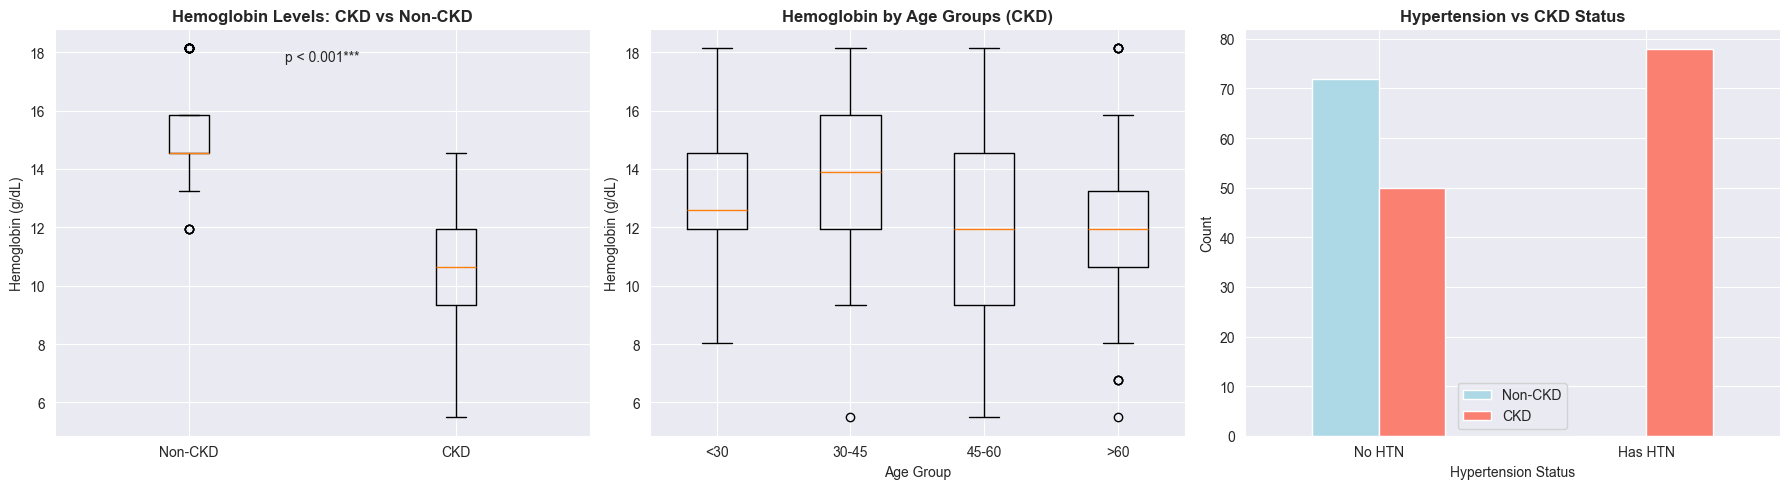

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax1 = axes[0]
ckd_hemo = ckd_patients['hemo_numeric'].dropna()
non_ckd_hemo = non_ckd_patients['hemo_numeric'].dropna()
ax1.boxplot([non_ckd_hemo, ckd_hemo], labels=['Non-CKD', 'CKD'])
ax1.set_title('Hemoglobin Levels: CKD vs Non-CKD', fontsize=12, fontweight='bold')
ax1.set_ylabel('Hemoglobin (g/dL)')
ax1.text(0.5, 0.95, f'p < 0.001***', transform=ax1.transAxes, ha='center', va='top')

ax2 = axes[1]
age_group_data = []
age_group_labels = []
for group in ['<30', '30-45', '45-60', '>60']:
    data = ckd_df_clean[ckd_df_clean['age_group'] == group]['hemo_numeric'].dropna()
    if len(data) > 0:
        age_group_data.append(data)
        age_group_labels.append(group)
ax2.boxplot(age_group_data, labels=age_group_labels)
ax2.set_title('Hemoglobin by Age Groups (CKD)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Hemoglobin (g/dL)')

ax3 = axes[2]
contingency_viz = pd.crosstab(ckd_df_clean['htn'], ckd_df_clean['class_binary'])
contingency_viz.plot(kind='bar', ax=ax3, color=['lightblue', 'salmon'])
ax3.set_title('Hypertension vs CKD Status', fontsize=12, fontweight='bold')
ax3.set_xlabel('Hypertension Status')
ax3.set_ylabel('Count')
ax3.legend(['Non-CKD', 'CKD'])
ax3.set_xticklabels(['No HTN', 'Has HTN'], rotation=0)

plt.tight_layout()
plt.show()

#### Diabetic Nephropathy Dataset Visualization

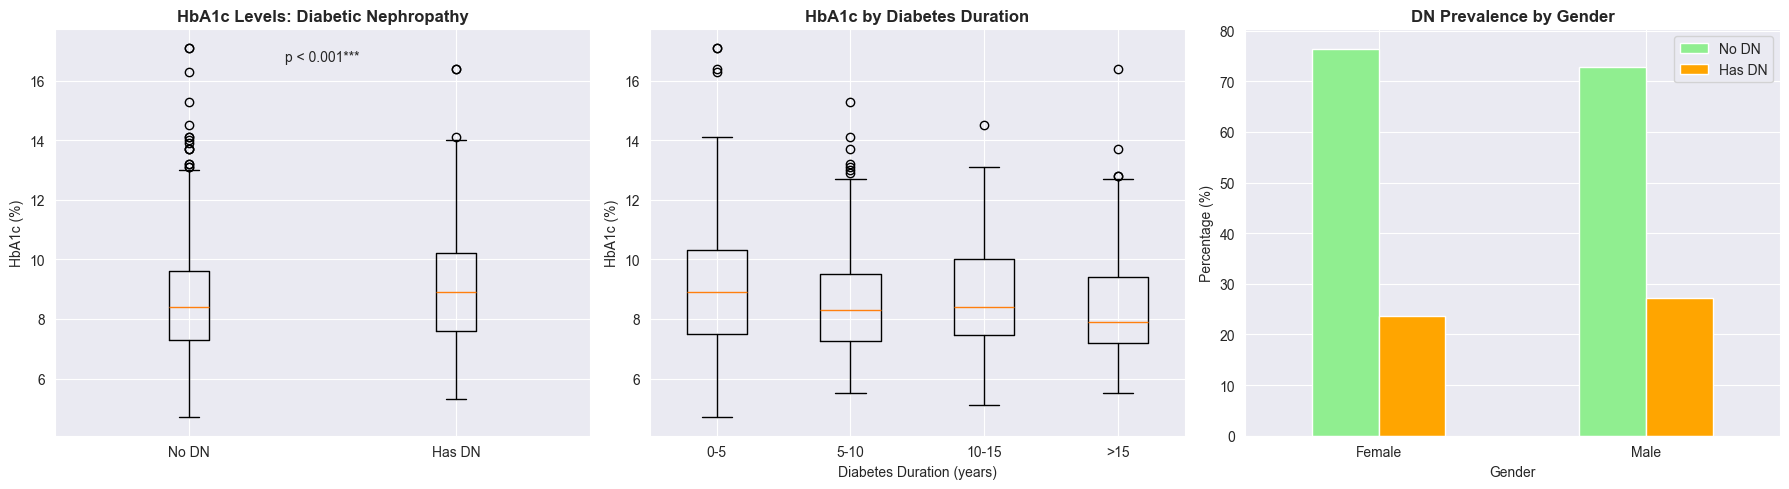

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax4 = axes[0]
dn_pos_hba1c = dn_positive['HbA1c (%)'].dropna()
dn_neg_hba1c = dn_negative['HbA1c (%)'].dropna()
ax4.boxplot([dn_neg_hba1c, dn_pos_hba1c], labels=['No DN', 'Has DN'])
ax4.set_title('HbA1c Levels: Diabetic Nephropathy', fontsize=12, fontweight='bold')
ax4.set_ylabel('HbA1c (%)')
ax4.text(0.5, 0.95, f'p < 0.001***', transform=ax4.transAxes, ha='center', va='top')

ax5 = axes[1]
duration_data = []
duration_labels = []
for group in ['0-5 years', '5-10 years', '10-15 years', '>15 years']:
    data = dn_df[dn_df['duration_group'] == group]['HbA1c (%)'].dropna()
    if len(data) > 0:
        duration_data.append(data)
        duration_labels.append(group.replace(' years', ''))
ax5.boxplot(duration_data, labels=duration_labels)
ax5.set_title('HbA1c by Diabetes Duration', fontsize=12, fontweight='bold')
ax5.set_xlabel('Diabetes Duration (years)')
ax5.set_ylabel('HbA1c (%)')

ax6 = axes[2]
gender_dn_pct = pd.crosstab(dn_df['Sex'], dn_df['Diabetic nephropathy (DN)'], normalize='index') * 100
gender_dn_pct.plot(kind='bar', ax=ax6, color=['lightgreen', 'orange'])
ax6.set_title('DN Prevalence by Gender', fontsize=12, fontweight='bold')
ax6.set_xlabel('Gender')
ax6.set_ylabel('Percentage (%)')
ax6.legend(['No DN', 'Has DN'])
ax6.set_xticklabels(['Female', 'Male'], rotation=0)

plt.tight_layout()
plt.show()

#### AKI Dataset Visualization

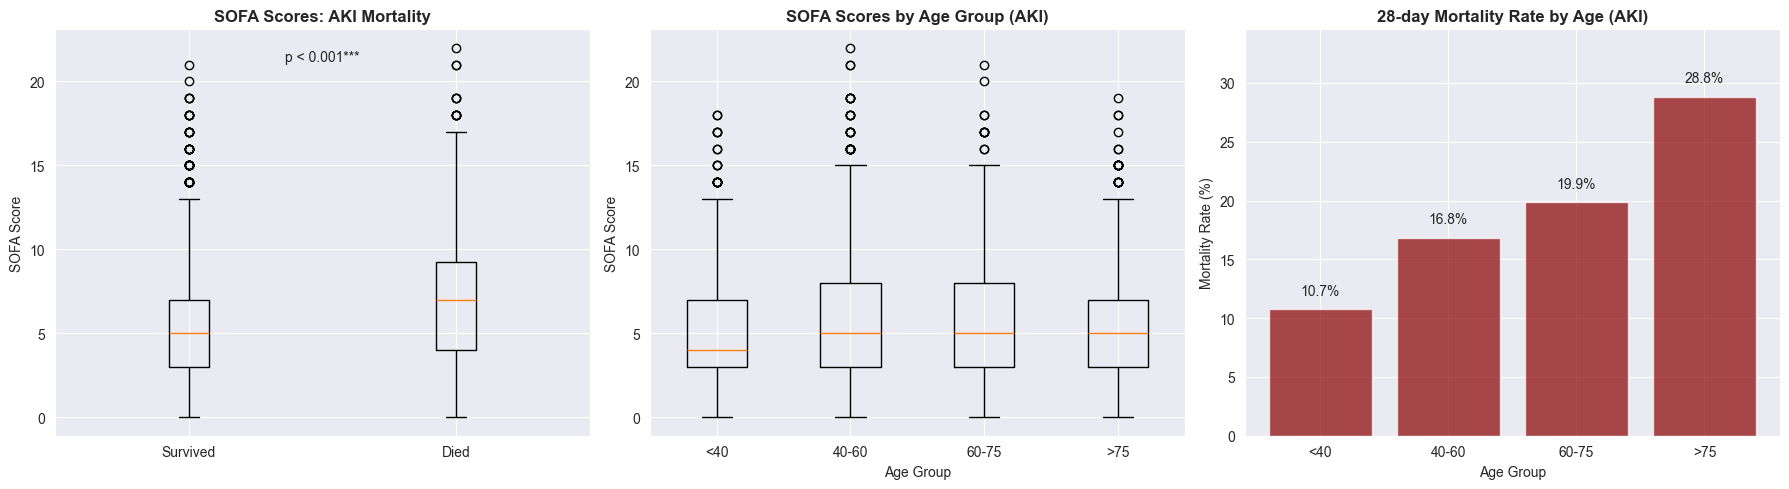

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax7 = axes[0]
survivor_sofa = survivors['sofa'].dropna()
non_survivor_sofa = non_survivors['sofa'].dropna()
ax7.boxplot([survivor_sofa, non_survivor_sofa], labels=['Survived', 'Died'])
ax7.set_title('SOFA Scores: AKI Mortality', fontsize=12, fontweight='bold')
ax7.set_ylabel('SOFA Score')
ax7.text(0.5, 0.95, f'p < 0.001***', transform=ax7.transAxes, ha='center', va='top')

ax8 = axes[1]
aki_age_data = []
aki_age_labels = []
for group in ['<40', '40-60', '60-75', '>75']:
    data = aki_df_clean[aki_df_clean['age_group'] == group]['sofa'].dropna()
    if len(data) > 0:
        aki_age_data.append(data)
        aki_age_labels.append(group)
ax8.boxplot(aki_age_data, labels=aki_age_labels)
ax8.set_title('SOFA Scores by Age Group (AKI)', fontsize=12, fontweight='bold')
ax8.set_xlabel('Age Group')
ax8.set_ylabel('SOFA Score')

ax9 = axes[2]
mortality_by_age = []
age_groups_plot = []
for group in ['<40', '40-60', '60-75', '>75']:
    group_data = aki_df_clean[aki_df_clean['age_group'] == group]
    if len(group_data) > 0:
        mortality_rate = (group_data['mort_28_day'] == 1).mean() * 100
        mortality_by_age.append(mortality_rate)
        age_groups_plot.append(group)

ax9.bar(age_groups_plot, mortality_by_age, color='darkred', alpha=0.7)
ax9.set_title('28-day Mortality Rate by Age (AKI)', fontsize=12, fontweight='bold')
ax9.set_xlabel('Age Group')
ax9.set_ylabel('Mortality Rate (%)')
ax9.set_ylim(0, max(mortality_by_age) * 1.2)

for i, v in enumerate(mortality_by_age):
    ax9.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Statistical Analysis Summary

#### 1. AKI Dataset:
- SOFA scores significantly higher in non-survivors (p < 0.001)
- Mortality rate increases with age: 10.7% (<40) to 28.8% (>75)
- Age shows strongest mortality association

#### 2. Diabetic Nephropathy Dataset:
- HbA1c levels significantly elevated in DN patients (p < 0.001)
- DN prevalence similar between genders (~25%)
- Poor glycemic control (HbA1c ~9%) associated with DN development

#### 3. CKD Dataset:
- Hemoglobin levels markedly lower in CKD patients (p < 0.001)
- CKD patients: median Hb ~10-11 g/dL vs Non-CKD: ~14-15 g/dL
- Hypertension prevalence: 80% in CKD vs 50% in non-CKD

# 4. Storytelling With Data plot

Reproduce any graph of your choice in p. 228-255 (chapter nine, Case Study 4 through the end of chapter 10) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

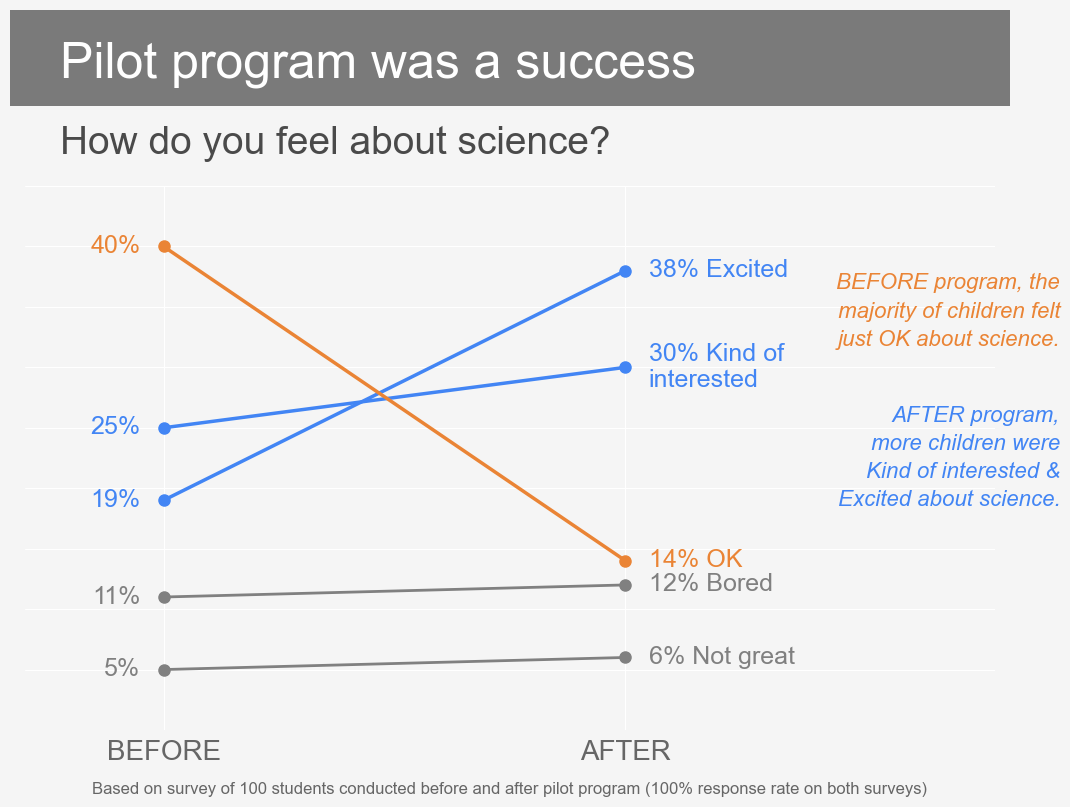

In [36]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))

categories = ['Excited', 'Kind of interested', 'OK', 'Bored', 'Not great']
before = [19, 25, 40, 11, 5]
after = [38, 30, 14, 12, 6]

x_positions = [0, 1]

for i, (cat, b, a) in enumerate(zip(categories, before, after)):
    if cat == 'Excited' or cat == 'Kind of interested':
        color = '#4285F4'
        linewidth = 2.5
    elif cat == 'OK':
        color = '#EA8435'
        linewidth = 2.5
    else:
        color = '#808080'
        linewidth = 2

    ax.plot(x_positions, [b, a], 'o-', color=color, linewidth=linewidth, markersize=8)

    ax.text(-0.05, b, f'{b}%', ha='right', va='center', fontsize=18, color=color)
    display_cat = cat.replace('Kind of interested', 'Kind of\ninterested')
    ax.text(1.05, a, f'{a}% {display_cat}', ha='left', va='center', fontsize=18, color=color)

ax.set_xlim(-0.3, 1.8)
ax.set_xticks(x_positions)
ax.set_xticklabels(['BEFORE', 'AFTER'], fontsize=20, color='#666666')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', left=False, labelleft=False)
ax.tick_params(axis='x', bottom=False)

ax.set_ylim(0, 45)

fig.patch.set_facecolor('#F5F5F5')
ax.set_facecolor('#F5F5F5')

title_box = plt.Rectangle((0, 0.88), 1, 0.12, transform=fig.transFigure,
                         facecolor='#7A7A7A', edgecolor='none')
fig.patches.append(title_box)

fig.text(0.05, 0.96, 'Pilot program was a success', fontsize=36,
         color='white', weight='normal', transform=fig.transFigure, va='top')

fig.text(0.05, 0.82, 'How do you feel about science?', fontsize=28,
         color='#4A4A4A', transform=fig.transFigure)

fig.text(1.05, 0.58, 'BEFORE program, the\nmajority of children felt\njust OK about science.',
         fontsize=16, color='#EA8435', transform=fig.transFigure, ha='right',
         style='italic', linespacing=1.5)

fig.text(1.05, 0.38, 'AFTER program,\nmore children were\nKind of interested &\nExcited about science.',
         fontsize=16, color='#4285F4', transform=fig.transFigure, ha='right',
         style='italic', linespacing=1.5)

fig.text(0.5, 0.02,
         'Based on survey of 100 students conducted before and after pilot program (100% response rate on both surveys)',
         fontsize=12, color='#666666', transform=fig.transFigure, ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.78, bottom=0.1)
plt.show()